# Structural Counterfactuals (SCF)

This is an example script where we try to understand Pearl's structural counterfactuals (SCF) generation process (abduction - action - prediction) in the context of situation testing (SI). 

We want to be able to take a factual tuple {$x^F$} and return it's counterfactual by changing the protected attribute $A$ from $a^F=a$ to $a^{SCF}=a'$. 

We believe to have two clear scenarios here regarding the latent space (or exogenous variables): either we have them by having generated ourselves the data or we don't and most estimate them using, e.g., MCMC. 

In [1]:
import random
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# set working directory - note: all code runs from the src folder
wrk_dir = os.getcwd()
# set data path
data_path = wrk_dir + '\\' + 'data' + '\\'

In [3]:
# overall params
random.seed(2022)
n = 1000

### Figure 1 from [Karimi et al. (2020)](https://arxiv.org/pdf/2002.06278.pdf)

Here, we create two synthetic datasets: v1 and v2. Version one (v1) is the original DAG from the paper, while version two (v2) we add gender and penalize the weights for females.

### Version 1: Causal Sufficiency
With the DAG: $X_1->Y$, $X_1->X_2$, $X_2->Y$.

In [4]:
# (hyper)parameters
# p_rate = 10
# n_mu = 0.0
# n_sigma = 1.0
lambda_1 = 10000
lambda_2 = 2500
beta_1 = (3/10)
beta_2 = 5
#epsilon = 225000

u1 = lambda_1*np.random.poisson(lam=10, size=n)
u2 = lambda_2*np.random.normal(loc=0.0, scale=1.0, size=n)

# annual salary
x1 = u1
# account balance
x2 = beta_1*x1 + u2
# loan approval
y = np.sign(x1 + beta_2*x2 - 225000)

In [5]:
# make a dataset for the observables and unobservables
# d = {'Y': y, 'X1': x1, 'X2': x2, 'U1_hat': lambda_1*u1, 'U2_hat': lambda_2*u2}
# data = pd.DataFrame(d)
# data.head(10)

# store data for testing RStan 
d = {'LoanApproval': y, 
     'AnnualSalary': x1, 
     'AccountBalance': x2,
     'u1': u1,
     'u2': u2}
data = pd.DataFrame(d)
data.head(10)

,LoanApproval,AnnualSalary,AccountBalance,u1,u2
0,1.0,180000,55254.156261,180000,1254.156261
1,-1.0,60000,15549.435970,60000,-2450.564030
2,1.0,90000,29560.549418,90000,2560.549418
3,-1.0,50000,16860.406037,50000,1860.406037
4,1.0,100000,28839.054734,100000,-1160.945266
5,1.0,110000,32336.729162,110000,-663.270838
6,-1.0,70000,20605.042420,70000,-394.957580
7,1.0,100000,29709.550535,100000,-290.449465
8,1.0,140000,41217.348581,140000,-782.651419
9,1.0,150000,40364.842778,150000,-4635.157222


In [ ]:
# store in data folder
data.to_csv(data_path + '\\' + 'Karimi2020_v1.csv', sep='|', index=False)

Can I say anything about the error terms' moments based on the 'observed' Us?

It seems that for the white noise, yes. Realistically, however, we assume to know $F$ and its moments - too restrictive for an additve noise model used for discrimination, no?

In [6]:
# recall u1 is a Poisson
print(round(np.mean(data['u1']), 1))
print(round(np.sqrt(np.var(data['u1'])), 1))

99200.0
31393.6


In [7]:
# recall u2 is a White Noise
print(round(np.mean(data['u2']), 1))
print(round(np.sqrt(np.var(data['u2'])), 1))

-32.9
2469.9


### (1) Estimate $f_j$

My interpretation of the paper is that, under causal sufficiency, focus is on estimating $f_j$ from the $X_j = f_j(X_{pa(j)}) + U$. If we 'assume' $f_j$ to be linar, the OLS estimator (being BLUE) is the best option, right? In other words,

$ X_j = \beta_0 + \sum \beta \times X_{par(j)} + U_j$

In [8]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True, normalize=False)

In [15]:
x = np.array(data['AnnualSalary'].copy()).reshape((-1, 1))
print(x.shape)
y = np.array(data['AccountBalance'].copy())
print(y.shape)

(1000, 1)
(1000,)


In [16]:
model.fit(x, y)

LinearRegression()

In [22]:
hat_beta1 = model.coef_[0]
hat_beta1

0.30117628968521337

In [23]:
hat_beta0 = model.intercept_
hat_beta0

-149.5884131678322

In [26]:
scf_data = data[['AnnualSalary', 'AccountBalance', 'u1', 'u2']].copy()
scf_data.head(5)

,AnnualSalary,AccountBalance,u1,u2
0,180000,55254.156261,180000,1254.156261
1,60000,15549.435970,60000,-2450.564030
2,90000,29560.549418,90000,2560.549418
3,50000,16860.406037,50000,1860.406037
4,100000,28839.054734,100000,-1160.945266


In [27]:
scf_data['hat_AccountBalance'] = model.predict(x)
scf_data.head(5)

,AnnualSalary,AccountBalance,u1,u2,hat_AccountBalance
0,180000,55254.156261,180000,1254.156261,54062.143730
1,60000,15549.435970,60000,-2450.564030,17920.988968
2,90000,29560.549418,90000,2560.549418,26956.277659
3,50000,16860.406037,50000,1860.406037,14909.226071
4,100000,28839.054734,100000,-1160.945266,29968.040555


In [44]:
scf_data['diff_AccountBalance'] = round(scf_data['AccountBalance'] - scf_data['hat_AccountBalance'], 2)
scf_data.head(5)

,AnnualSalary,AccountBalance,u1,u2,hat_AccountBalance,diff_AccountBalance,perc_diff_AccountBalance
0,180000,55254.156261,180000,1254.156261,54062.143730,1192.01,2.16
1,60000,15549.435970,60000,-2450.564030,17920.988968,-2371.55,15.25
2,90000,29560.549418,90000,2560.549418,26956.277659,2604.27,8.81
3,50000,16860.406037,50000,1860.406037,14909.226071,1951.18,11.57
4,100000,28839.054734,100000,-1160.945266,29968.040555,-1128.99,3.91


(array([  7.,  44.,  87., 182., 307., 205., 113.,  43.,   8.,   4.]),
 array([-7659.37 , -5994.676, -4329.982, -2665.288, -1000.594,   664.1  ,
         2328.794,  3993.488,  5658.182,  7322.876,  8987.57 ]),
 <BarContainer object of 10 artists>)

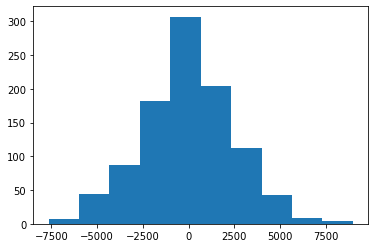

In [45]:
plt.hist(scf_data['diff_AccountBalance'])

In [46]:
scf_data['perc_diff_AccountBalance'] = round( np.sqrt( (scf_data['AccountBalance'] - scf_data['hat_AccountBalance'])**2 ) * 100 / scf_data['AccountBalance'], 2)
scf_data.head(10)

,AnnualSalary,AccountBalance,u1,u2,hat_AccountBalance,diff_AccountBalance,perc_diff_AccountBalance
0,180000,55254.156261,180000,1254.156261,54062.143730,1192.01,2.16
1,60000,15549.435970,60000,-2450.564030,17920.988968,-2371.55,15.25
2,90000,29560.549418,90000,2560.549418,26956.277659,2604.27,8.81
3,50000,16860.406037,50000,1860.406037,14909.226071,1951.18,11.57
4,100000,28839.054734,100000,-1160.945266,29968.040555,-1128.99,3.91
5,110000,32336.729162,110000,-663.270838,32979.803452,-643.07,1.99
6,70000,20605.042420,70000,-394.957580,20932.751865,-327.71,1.59
7,100000,29709.550535,100000,-290.449465,29968.040555,-258.49,0.87
8,140000,41217.348581,140000,-782.651419,42015.092143,-797.74,1.94
9,150000,40364.842778,150000,-4635.157222,45026.855040,-4662.01,11.55


In [47]:
# can we start talking about a threshold here?
error_threshold = 5.0

scf_data[scf_data['perc_diff_AccountBalance'] <= error_threshold].shape

(476, 7)

(array([  7.,  44.,  87., 182., 307., 205., 113.,  43.,   8.,   4.]),
 array([-7659.37 , -5994.676, -4329.982, -2665.288, -1000.594,   664.1  ,
         2328.794,  3993.488,  5658.182,  7322.876,  8987.57 ]),
 <BarContainer object of 10 artists>)

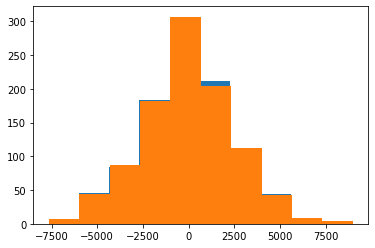

In [48]:
plt.hist(scf_data['u2'])
plt.hist(scf_data['diff_AccountBalance'])

From the histograms of above, it seems that under cuasal sufficiency the abduction step essentially represents the individual error terms!

### (2) Abduction

In [49]:
scf_data['hat_u1'] = scf_data['AnnualSalary']
scf_data['hat_u2'] = round(scf_data['AccountBalance'] - model.predict(x), 2)
scf_data.head(5)

,AnnualSalary,AccountBalance,u1,u2,hat_AccountBalance,diff_AccountBalance,perc_diff_AccountBalance,hat_u1,hat_u2
0,180000,55254.156261,180000,1254.156261,54062.143730,1192.01,2.16,180000,1192.01
1,60000,15549.435970,60000,-2450.564030,17920.988968,-2371.55,15.25,60000,-2371.55
2,90000,29560.549418,90000,2560.549418,26956.277659,2604.27,8.81,90000,2604.27
3,50000,16860.406037,50000,1860.406037,14909.226071,1951.18,11.57,50000,1951.18
4,100000,28839.054734,100000,-1160.945266,29968.040555,-1128.99,3.91,100000,-1128.99


In [50]:
scf_data = scf_data[['AnnualSalary', 'AccountBalance', 'hat_u1', 'hat_u2']]
scf_data.head(5)

,AnnualSalary,AccountBalance,hat_u1,hat_u2
0,180000,55254.156261,180000,1192.01
1,60000,15549.435970,60000,-2371.55
2,90000,29560.549418,90000,2604.27
3,50000,16860.406037,50000,1951.18
4,100000,28839.054734,100000,-1128.99


### ... and Intervention and Prediction

In [52]:
round(np.mean(scf_data['AccountBalance']))

29727

In [58]:
do = 30000
do_30000 = np.repeat(do, repeats=scf_data.shape[0]).reshape((-1, 1))
do_30000

array([[30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [30000],
       [

In [61]:
scf_data['scf_AccountBalance'] = round(model.predict(do_30000) + scf_data['hat_u2'], 2)
scf_data.head(5)

,AnnualSalary,AccountBalance,hat_u1,hat_u2,scf_AccountBalance
0,180000,55254.156261,180000,1192.01,10077.71
1,60000,15549.435970,60000,-2371.55,6514.15
2,90000,29560.549418,90000,2604.27,11489.97
3,50000,16860.406037,50000,1951.18,10836.88
4,100000,28839.054734,100000,-1128.99,7756.71


(array([  7.,  44.,  87., 182., 307., 205., 113.,  43.,   8.,   4.]),
 array([ 1226.33 ,  2891.024,  4555.718,  6220.412,  7885.106,  9549.8  ,
        11214.494, 12879.188, 14543.882, 16208.576, 17873.27 ]),
 <BarContainer object of 10 artists>)

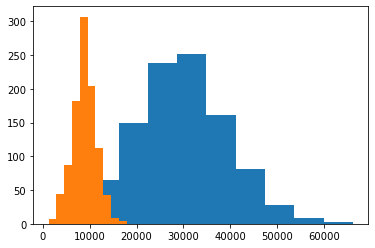

In [63]:
plt.hist(scf_data['AccountBalance'])
plt.hist(scf_data['scf_AccountBalance'])

In [ ]:
print(np.mean(u1))
print(np.var(u1))
plt.hist(u1)

In [ ]:
print(np.mean(lambda_1*u1))
print(np.var(lambda_1*u1))
plt.hist(lambda_1*u1)

In [ ]:
print(np.mean(u2))
print(np.var(u2))
plt.hist(u2)

In [ ]:
print(lambda_2*np.mean(u2)) # constant times mu
print((lambda_2**2)*np.var(u2)) # constant squared times sigma-squared

print(np.mean(lambda_2*u2))
print(np.var(lambda_2*u2))
plt.hist(lambda_2*u2)

Unclear to me what $\alpha$ represents here beyond generating data. When we use MCMC and consider $\alpha$*$U$, we no longer have an additive noise model with white noise... but we re-scale and re-shape the distribution of $U$. Then the MCMC cannot move away easily from the non-informative priors we set up to build $\hat{U}$.

We really need to reconsider what something like $X_1 := \beta*X_2 + \alpha_2*U_2$ means in practice (i.e. estimation).

Using this synthetic data we can generate the counterfactuals and we can, in turn, run the situation testing. Ofc, this is somewhat meaningless in the real world because we don't know the latent space. That's where MCMC comes... in the Kusner paper, it makes sense in terms of accounting for the confaunding effect of knowledge and that could be argued in the paper. However, say in a causal sufficiency situation, then it is not clear what abduction does other than saying $\hat{U_1} = X_1$, which is somewhat of a trivial finding and doesn't add much to the counterfactual estimation approach proposed by Pearl.

What might be interesting is breaking down $U$ into something more tangible rather than added noise... that really doesn't make much sense. Like what would it mean for SI to do the abduction step?

In [ ]:
# plot the factual distribution
plt.hist(y)

In [ ]:
# # make a dataset for the observables and unobservables
# d = {'Y': y, 'X1': x1, 'X2': x2, 'U1_hat': lambda_1*u1, 'U2_hat': lambda_2*u2}
# data = pd.DataFrame(d)
# data.head(10)

# store data for testing RStan 
d_test = {'LoanApproval': y, 
          'AnnualSalary': x1, 
          'AccountBalance': x2,
          'u1': u1,
          'l_u1': lambda_1*u1,
          'u2': u2,
          'l_u2': lambda_2*u2}
data_test = pd.DataFrame(d_test)
data_test.head(10)

In [ ]:
plt.hist(data_test['AnnualSalary'])

In [ ]:
plt.hist(data_test['AccountBalance'])

In [ ]:
# store in data folder
data_test.to_csv(data_path + '\\' + 'Karimi2020_v1.csv', sep='|', index=False)

In [ ]:
# make a dataset for the observables and unobservables
d = {'Y': y, 'X1': x1, 'X2': x2, 'U1_hat': lambda_1*u1, 'U2_hat': lambda_2*u2}
data = pd.DataFrame(d)
data.head(10)

In [ ]:
# consider individual i: what is the counterfactual of y_i?
# here, in ST, want the STRUCTURAL COUNTERFACTUAL x_scf, not too interested in y_scf
# because want to match x_scf with those that don't share the protected attribute memebership of i
i = 3
data.loc[i, ]

In [ ]:
# Step 1: Abduction
# Get U's given the evidence X's [assuming causal sufficiency and, ofc, a known causal graph]

# u1 given x1: from Fig.1, x1 = u1 and thus u1 = x1
u1_i = data.loc[i, 'X1']
print(u1_i)

# u2 given x2: from Fig.1, x2 = (3/10)*x1 + u2 and thus u2 = x2 - (3/10)*x1
u2_i = data.loc[i, 'X2'] - (3/10)*data.loc[i, 'X1']
print(u2_i)

In [ ]:
# Step 2: Action
# Given the SCM, intervene it accordingly using the do-operator 
delta = 5000

# Org SCM M:
# x1 = u1             [salary]
# x2 = (3/10)*x1 + u2 [balance]

# do(X1 := X1 + delta), then M':
# X1' := X1 + delta
# X2 = (3/10)*X1' + U2

# Step 3: Prediction (notice at at i-level)
# Apply the chagnes on M' and get the scf tuple 

x1_i_scf = data.loc[i, 'X1'] + delta
print(x1_i_scf)

x2_i_scf = (3/10)*x1_i_scf + u2_i
print(x2_i_scf)

In [ ]:
print(data.loc[i, 'Y'])
# vs
print(np.sign(x1_i_scf + 5*x2_i_scf - 225000))

This abduction-action-prediction from Karimi et al. is very usful for situation testing because all the focus is on profucing the structural counterfactual tuple for the attribute space; we don't 'care' for Y!

This means, wrt to ST, that we can generate X_CF without having to know the decision-maker (i.e., model agnostic). Ofc, the assumption here is that we have a SCM model that is known. Further more, SCM needs to be estimated to obtain the functional form for carrying out the three steps... meaning that we further have to assume (potentially) (1) causal sufficiency and (2) additive noise models for a nice estimation. Although these are considerable assumptions, it's standard within the literature.

ST simplifies this step in that we only care about switching the protected attribute A, which is usually 0 or 1. Further, we are not interested in flipping the decision, but in checking whether the decision flips or not!

Furthermore, we should consider the types of potential interventions presented in this paper... and extend situation testing beyond flipping A?!

Given {x^F}, we can generate {x^SCF} and from this generated tuple try to match individuals that don't share the protected attribute of the complainant... creating out counterfactual group.

In practice, we won't have access to U (i.e., the latent space) but we can approximated using MCMC (like in Kusner at al.).

### v2
with the DAG: X1->Y, X1->X2, X->Y, A->X1, A->X2 such that $A$ is gender (A=1 female, A=0 male).

In [ ]:
p_men = 0.65
uA = random.choices(population=[0, 1], weights=[p_men, (1 - p_men)], k=n)
plt.hist(uA)

In [ ]:
#u1 = 10000*np.random.poisson(lam=10, size=n)
#u2 = 2500*np.random.normal(loc=0.0, scale=1.0, size=n)
#uA = see previous cell!

# gender 
A = np.asanyarray(uA)
# and its weights (systematic issue) | we avoid direct effects (as it would be ilegal and inline with Hecker's view)
beta1 = -9500
beta2 = -500

# annual salary
n_x1 = lambda_1*u1 + beta1*A
# account balance
n_x2 = (3/10)*n_x1 + lambda_2*u2 + beta2*A
# loan approval
n_y = np.sign(n_x1 + 5*n_x2 - 225000)

In [ ]:
# plot the factual distribution
plt.hist(n_y)

In [ ]:
# store data for testing RStan 
d_test = {'LoanApproval': n_y, 
          'AnnualSalary': n_x1, 
          'AccountBalance': n_x2,
          'Gender': A,
          'u1': u1,
          'l_u1': lambda_1*u1,
          'u2': u2,
          'l_u2': lambda_2*u2}
data_test = pd.DataFrame(d_test)
data_test.head(10)

In [ ]:
# store in data folder
data_test.to_csv(data_path + '\\' + 'Karimi2020_v2.csv', sep='|', index=False)

In [ ]:
# make a dataset for the observables*
# *include unobservables too... here, imagine you ran the MCMC before and estimated u|evidence
d = {'Y': y, 'X1': x1, 'X2': x2, 
     'Gender': A, 'nY': n_y, 'nX1': n_x1, 'nX2': n_x2,
     'U1_hat': u1, 'U2_hat': u2, 'uA': uA}
data = pd.DataFrame(d)
data.head(10)

In [ ]:
# total of females
n_f = data[data['Gender']==1].shape[0]
# total of males
n_m = data[data['Gender']==0].shape[0]

# unbiased
print('female unbiased')
print(data[(data['Gender']==1) & (data['Y']==1)].shape[0] / n_f)
print('male unbiased')
print(data[(data['Gender']==0) & (data['Y']==1)].shape[0] / n_m)

# biased
print('female biased')
print(data[(data['Gender']==1) & (data['nY']==1)].shape[0] / n_f)
print('male biased')
print(data[(data['Gender']==0) & (data['nY']==1)].shape[0] / n_m)

# TODO: would this show in a trained model?

### Would this translate into some trained model?

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression, Lasso
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from sklearn.neural_network import MLPClassifier
# from sklearn.tree import DecisionTreeClassifier
# from xgboost import XGBRegressor, XGBClassifier
# from catboost import CatBoostClassifier

In [ ]:
data.columns

In [ ]:
u_data = data[['Y', 'X1', 'X2', 'Gender']].copy()
print(u_data.shape)

b_data = data[['nY', 'nX1', 'nX2', 'Gender']].copy()
print(b_data.shape)

In [ ]:
# todo: let's do a simple logit here, later we can reuse the FairEncoder code and streamline multiple models
# todo: also create an utils files accordingly
# todo: get comfortable with Pipeline

b_data['nY2'] = np.where(b_data['nY']==-1, 0 ,b_data['nY'])
print(b_data[['nY', 'nY2']].head(10))

targets = ['nY2', 'nY']
y = b_data['nY2']
X = b_data.drop(columns=targets)

In [ ]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.5, random_state=42)

In [ ]:
clf = LogisticRegression(random_state=0).fit(X_tr, y_tr.values.ravel())

In [ ]:
clf.coef_

In [ ]:
y_pr = clf.predict(X_te)

In [ ]:
conf_matrix = confusion_matrix(y_pr, y_te)
conf_matrix

In [ ]:
# todo: move later to some utils.py files 
def calculate_cm(true, preds):
    
    # Obtain the confusion matrix
    cm = confusion_matrix(preds, true)
    
    # Return all
    cm_dict = dict()

    #  https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
    FP = cm.sum(axis=0) - np.diag(cm)
    cm_dict['FP'] = FP
    FN = cm.sum(axis=1) - np.diag(cm)
    cm_dict['FN'] = FN
    TP = np.diag(cm)
    cm_dict['TP'] = TP
    TN = cm.sum() - (FP + FN + TP)
    cm_dict['TN'] = TN
    
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP / (TP + FN)
    cm_dict['TPR'] = TPR
    # Specificity or true negative rate
    TNR = TN / (TN + FP)
    cm_dict['TNR'] = TNR
    
    # todo: expand dict for others
    # Precision or positive predictive valbue
    PPV = TP / (TP + FP)
    # Negative predictive value
    NPV = TN / (TN + FN)
    # Fall out or false positive rate
    FPR = FP / (FP + TN)
    # False negative rate
    FNR = FN / (TP + FN)
    # False discovery rate
    FDR = FP / (TP + FP)

    # Overall accuracy
    ACC = (TP + TN) / (TP + FP + FN + TN)

    #return cm_dict
    return TPR[0] #esto esta bien!

In [ ]:
# reference group (males, or A=0): group 2
aux = X_te.copy()
aux['target'] = y_te

# Filter the data
g1 = X_te[X_te['Gender'] == 1]
g2 = X_te[X_te['Gender'] == 0]

# Filter the ground truth
g1_true = aux[aux['Gender'] == 1].target
g2_true = aux[aux['Gender'] == 0].target

# Do predictions
p1 = clf.predict(g1)
p2 = clf.predict(g2)

# Extract metrics for each group | here, taking the true positive rate
res1 = calculate_cm(p1, g1_true)
print(res1)
res2 = calculate_cm(p2, g2_true)
print(res2)

res1 - res2

In [ ]:
#https://www.analyticsvidhya.com/blog/2020/04/confusion-matrix-machine-learning/
# TPR = TP / (TP + FP)

print(confusion_matrix(p1, g1_true))
tpr_1 = confusion_matrix(p1, g1_true)[0][0] / (confusion_matrix(p1, g1_true)[0][0] + confusion_matrix(p1, g1_true)[0][1])
print(tpr_1)

print(confusion_matrix(p2, g2_true))
tpr_2 = confusion_matrix(p2, g2_true)[0][0] / (confusion_matrix(p2, g2_true)[0][0] + confusion_matrix(p2, g2_true)[0][1])
print(tpr_2)

In [ ]:
def metric_calculator(model, data: pd.DataFrame, truth: pd.DataFrame, col: str, group1, group2):
    #reference group is group2!!
    
    aux = data.copy()
    aux["target"] = truth

    # Filter the data
    g1 = data[data[col] == group1]
    g2 = data[data[col] == group2]

    # Filter the ground truth
    g1_true = aux[aux[col] == group1].target
    g2_true = aux[aux[col] == group2].target

    # Do predictions
    p1 = model.predict(g1)
    p2 = model.predict(g2)

    # Extract metrics for each group | here, taking the true positive rate
    res1 = calculate_cm(p1, g1_true)
    print(res1)
    res2 = calculate_cm(p2, g2_true)
    print(res2)
    
    return res1 - res2

In [ ]:
metric_calculator(model=clf, data=X_te, truth=y_te, col='Gender', group1=1, group2=0)

In [ ]:
metric_calculator(model=clf, data=X_tr, truth=y_tr, col='Gender', group1=1, group2=0)